In [10]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.4 MB/s eta 0:00:00a 0:00:01


In [68]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

num_nodes = 50
G = nx.erdos_renyi_graph(n=num_nodes, p=0.3, seed=42)
edges = list(G.edges())
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Initial node features and labels
def generate_features_labels():
    features = []
    labels = []
    for i in range(num_nodes):
        queue_len = random.randint(0, 100)
        load = random.randint(0, 100)
        utilization = random.random()
        features.append([queue_len, load, utilization])
        labels.append(1 if (queue_len > 70 or load > 80 or utilization > 0.8) else 0)
    features = torch.tensor(features, dtype=torch.float)
    features = features / features.max(dim=0)[0]  # normalization
    labels = torch.tensor(labels, dtype=torch.long)
    return features, labels

features, labels = generate_features_labels()
features = features / features.max(dim=0)[0]  #normalization
feature_names = ['queue_len', 'load', 'utilization']
for n in range(num_nodes):
    G.nodes[n]['queue_len'] = features[n, 0].item()
    G.nodes[n]['load'] = features[n, 1].item()
    G.nodes[n]['utilization'] = features[n, 2].item()


data = Data(x=features.clone(), edge_index=edge_index, y=labels.clone())

In [42]:
data.x[:, 2]

tensor([0.0254, 0.2266, 0.6869, 0.5993, 0.0951, 0.6110, 0.7268, 0.4258, 0.2824,
        0.8179, 0.3454, 0.9716, 0.0941, 0.8602, 0.8192, 0.5443, 0.5603, 0.8987,
        0.1952, 0.6712, 1.0000, 0.3858, 0.8466, 0.3606, 0.7123, 0.0725, 0.5422,
        0.4692, 0.6985, 0.3291, 0.0568, 0.4072, 0.9268, 0.3194, 0.4016, 0.1450,
        0.7562, 0.7582, 0.4054, 0.5172, 0.0478, 0.6369, 0.6054, 0.6048, 0.2552,
        0.6905, 0.8981, 0.7801, 0.2979, 0.0033])

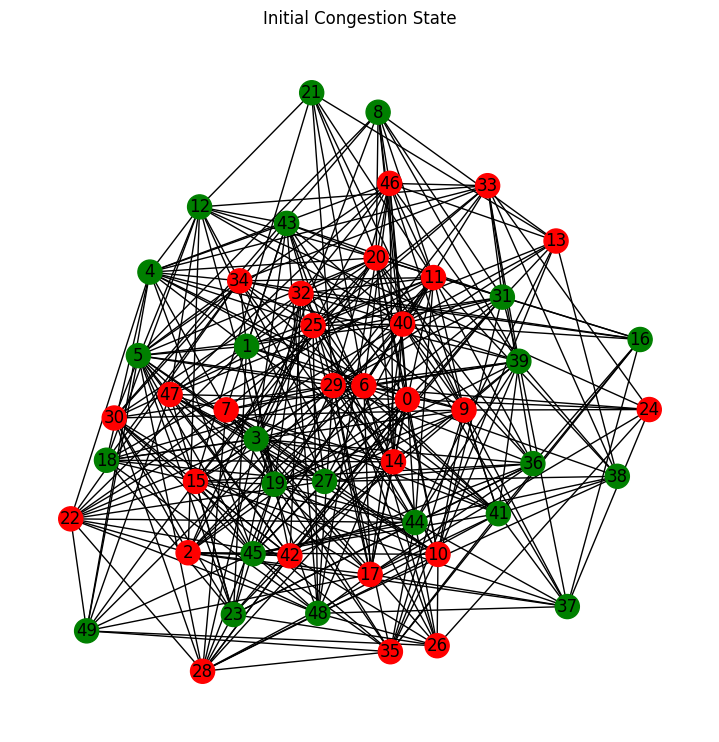

In [15]:
# Initial visualization (before training/feedback)
init_colors = ['red' if label == 1 else 'green' for label in labels]
plt.figure(figsize=(7,7))
nx.draw(G, with_labels=True, node_color=init_colors)
plt.title("Initial Congestion State")
plt.show()

In [16]:
# Define GNN with GAT layers
class GNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(3, 64, heads=2)
        self.conv2 = GATConv(128, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        return F.log_softmax(x, dim=1)



In [22]:
original_labels = labels.clone()

In [25]:
model = GNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.NLLLoss()

Epoch 0, Loss: 0.6914, Accuracy: 0.54
Epoch 20, Loss: 0.6805, Accuracy: 0.56
Epoch 40, Loss: 0.6620, Accuracy: 0.60
Epoch 60, Loss: 0.6450, Accuracy: 0.58
Epoch 80, Loss: 0.6289, Accuracy: 0.60
Epoch 100, Loss: 0.5930, Accuracy: 0.66
Epoch 120, Loss: 0.5526, Accuracy: 0.70
Epoch 140, Loss: 0.5245, Accuracy: 0.70
Epoch 160, Loss: 0.5095, Accuracy: 0.72
Epoch 180, Loss: 0.5001, Accuracy: 0.68
Epoch 200, Loss: 0.4926, Accuracy: 0.70
Epoch 220, Loss: 0.4862, Accuracy: 0.70
Epoch 240, Loss: 0.4756, Accuracy: 0.70
Epoch 260, Loss: 0.4650, Accuracy: 0.72
Epoch 280, Loss: 0.4518, Accuracy: 0.72
Epoch 300, Loss: 0.4358, Accuracy: 0.74
Epoch 320, Loss: 0.4177, Accuracy: 0.76
Epoch 340, Loss: 0.3927, Accuracy: 0.86
Epoch 360, Loss: 0.3693, Accuracy: 0.82
Epoch 380, Loss: 0.3486, Accuracy: 0.90
Epoch 400, Loss: 0.3340, Accuracy: 0.90
Epoch 420, Loss: 0.3228, Accuracy: 0.88
Epoch 440, Loss: 0.3138, Accuracy: 0.88
Epoch 460, Loss: 0.3043, Accuracy: 0.88
Epoch 480, Loss: 0.2963, Accuracy: 0.90
Epoch 

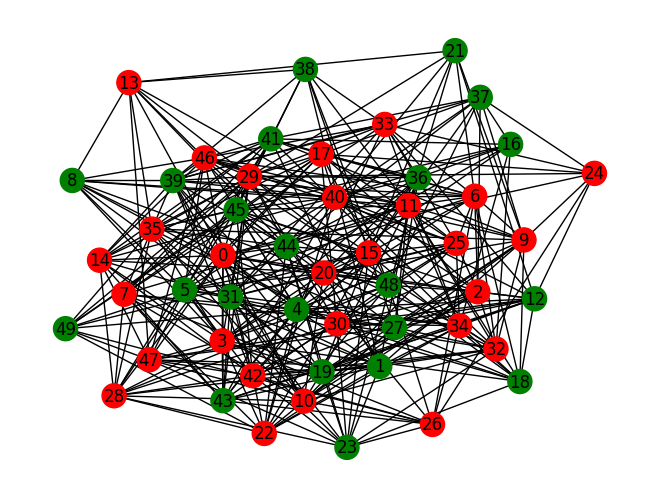

In [26]:
for epoch in range(2000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        pred = out.argmax(dim=1)
        acc = (pred == data.y).sum().item() / num_nodes
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Accuracy: {acc:.2f}")


pred_labels = model(data).argmax(dim=1).detach().numpy()
colors = ['red' if label==1 else 'green' for label in pred_labels]
nx.draw(G, with_labels=True, node_color=colors)
plt.show()


In [28]:
# For node 0 (or any node id)
print(G.nodes[0].keys())


dict_keys([])


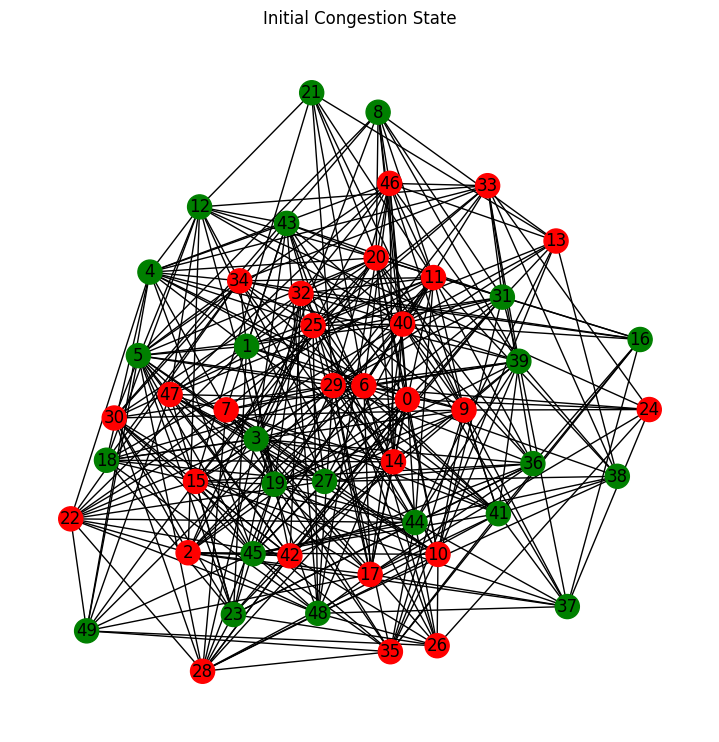

In [69]:
# Initial visualization (before training/feedback)
init_colors = ['red' if label == 1 else 'green' for label in labels]
plt.figure(figsize=(7,7))
nx.draw(G, with_labels=True, node_color=init_colors)
plt.title("Initial Congestion State")
plt.show()

In [70]:
model = GNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.NLLLoss()

Load propagation model implementation

Epoch 0 | MaxQ: 1.00 | AvgQ: 0.52 | StdQ: 0.32 | CongNodes: 20 | Fairness: 0.73
Epoch 20 | MaxQ: 0.81 | AvgQ: 0.52 | StdQ: 0.20 | CongNodes: 3 | Fairness: 0.87
Epoch 40 | MaxQ: 0.71 | AvgQ: 0.52 | StdQ: 0.20 | CongNodes: 12 | Fairness: 0.87
Epoch 60 | MaxQ: 0.71 | AvgQ: 0.52 | StdQ: 0.20 | CongNodes: 11 | Fairness: 0.87
Epoch 80 | MaxQ: 0.70 | AvgQ: 0.52 | StdQ: 0.20 | CongNodes: 12 | Fairness: 0.87
Epoch 100 | MaxQ: 0.70 | AvgQ: 0.52 | StdQ: 0.20 | CongNodes: 11 | Fairness: 0.87
Epoch 120 | MaxQ: 0.70 | AvgQ: 0.52 | StdQ: 0.20 | CongNodes: 12 | Fairness: 0.87
Epoch 140 | MaxQ: 0.70 | AvgQ: 0.52 | StdQ: 0.20 | CongNodes: 11 | Fairness: 0.87
Epoch 160 | MaxQ: 0.70 | AvgQ: 0.52 | StdQ: 0.20 | CongNodes: 12 | Fairness: 0.87
Epoch 180 | MaxQ: 0.70 | AvgQ: 0.52 | StdQ: 0.20 | CongNodes: 11 | Fairness: 0.87
Epoch 200 | MaxQ: 0.70 | AvgQ: 0.52 | StdQ: 0.20 | CongNodes: 12 | Fairness: 0.87
Epoch 220 | MaxQ: 0.70 | AvgQ: 0.52 | StdQ: 0.20 | CongNodes: 11 | Fairness: 0.87
Epoch 240 | MaxQ: 0.70 

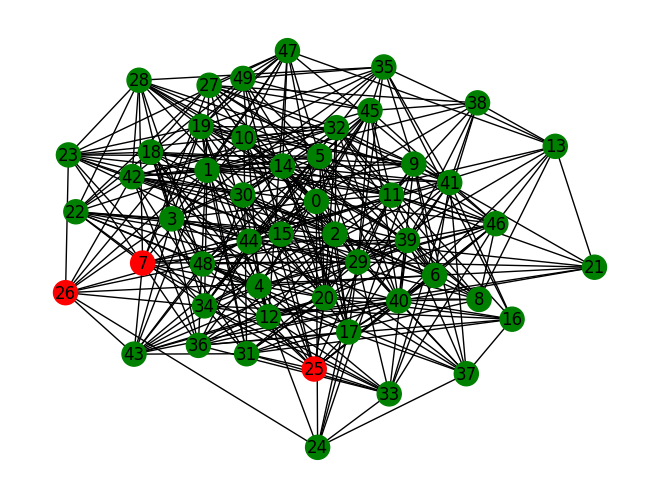

In [71]:
threshold = 0.7  # Congestion threshold (normalized)

for epoch in range(3000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    
    if epoch % 20 == 0:
        queue_lens = data.x[:, 0].detach().numpy()
        max_queue = queue_lens.max()
        avg_queue = queue_lens.mean()
        std_queue = queue_lens.std()
        num_congested = (queue_lens > threshold).sum()
        fairness = (queue_lens.sum())**2 / (num_nodes * (queue_lens**2).sum() + 1e-8)
        print(f"Epoch {epoch} | MaxQ: {max_queue:.2f} | AvgQ: {avg_queue:.2f} | StdQ: {std_queue:.2f} | CongNodes: {num_congested} | Fairness: {fairness:.2f}")

        # Congestion feedback loop
        for n in range(num_nodes):
            if queue_lens[n] > threshold:
                neighbors = [nb for nb in G.neighbors(n) if queue_lens[nb] <= threshold]
                if not neighbors:
                    continue
                excess = queue_lens[n] - threshold
                # Redistribute excess only
                for nb in neighbors:
                    G.nodes[nb]['queue_len'] += excess / len(neighbors)
                G.nodes[n]['queue_len'] = threshold  # Set to threshold after redistribution

        # Update PyG features
        data.x = torch.tensor([[G.nodes[n]['queue_len'], G.nodes[n]['load'], G.nodes[n]['utilization']] for n in range(num_nodes)], dtype=torch.float)

# Visualization
queue_lens = data.x[:, 0].detach().numpy()
colors = ['red' if q > threshold else 'green' for q in queue_lens]
nx.draw(G, with_labels=True, node_color=colors)
plt.show()
